# BPL_TEST2_Batch_design_space - demo

Author: Jan Peter Axelsson

In this notebook the design space for a batch cultivation process is determined and visualized. The example is kept as simple as possible. The culture grow on a substrate S and the cell conentration X inrease until the substrate is consumed. We study the problem first without any measurement noise and then later with measurement noise and use one separate FMU for each.

The end criteria for a batch is here when the subdstrate level has decreased below a certain predefined level and that time is called time_final:
* S < Smin

The evaluation of the batch culture is just in terms of the obtained value of cell concentration at the end in combination with how long time the culture took. The batch is accepted provided the culture fullfil the two requirements:

* X_final > X_final_min
* Time_final < time_final_max

The question is what range of process parameters Y and qSmax that can be allowed to still get accepted batches.

Here we simply use brute force and sweep through a number combinations of process parameters and evaluate by simulation the result for each parameter setting. We get rather clear-cut corners in the process parameter space that result in acceptable batches. 

In the later part we introduce substrate measurement error and in this way introduce some uncertainty in the determination of end of batch. The impact of this measurement noise is that the design space get more rounded corners.

The practical experimental approach is usually to just use a few parameter combinations and evaluate these and from that information calculate the design space. Usually "process linearity" assumption is used. The combination of this experimental approach with brute force simulation is discussed in reference [1].

## 1 Batch end detection - no measurement noise 

Here we load a system model without noise. Thus detection of end of batch is an event in continuous time.

In [1]:
run -i BPL_TEST2_Batch_no_noise_explore.py

Linux - run FMU pre-compiled OpenModelica

Model for the process has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values/units

Note that both disp() and describe() takes values from the last simulation
and the command process_diagram() brings up the main configuration

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [2]:
# Adjust the diagrm size
plt.rcParams['figure.figsize'] = [30/2.54, 24/2.54]

## 1.1 Batch evaluation

The first an example of batch that has an end of batch that fulfills the criteria for acceptance.  In the following diagram we see examples of impact of variation on the criteria for acceptance. 

The variable batch_evaluation goes from 0 to either 1 or a negative value when end of batch is detected. A positive value 1 means that the acceptance criteria is fullfilled and a negative value -1, -2 or -3 is obtained if one or more criteria for acceptance is not fullfilled.

In [3]:
# Nominal parameters
par(S_min=1.0, time_final_max=6.0, X_final_min=5.0)
init(VX_start=2, VS_start=10)
par(Y=0.5, qSmax=0.5, Ks=0.1)

Could not find cannot import name 'dopri5' from 'assimulo.lib' (/home/janpeter/miniconda3/envs/pyfmi/lib/python3.12/site-packages/assimulo/lib/__init__.py)
Could not find cannot import name 'rodas' from 'assimulo.lib' (/home/janpeter/miniconda3/envs/pyfmi/lib/python3.12/site-packages/assimulo/lib/__init__.py)
Could not find cannot import name 'odassl' from 'assimulo.lib' (/home/janpeter/miniconda3/envs/pyfmi/lib/python3.12/site-packages/assimulo/lib/__init__.py)
Could not find ODEPACK functions.
Could not find RADAR5
Could not find GLIMDA.


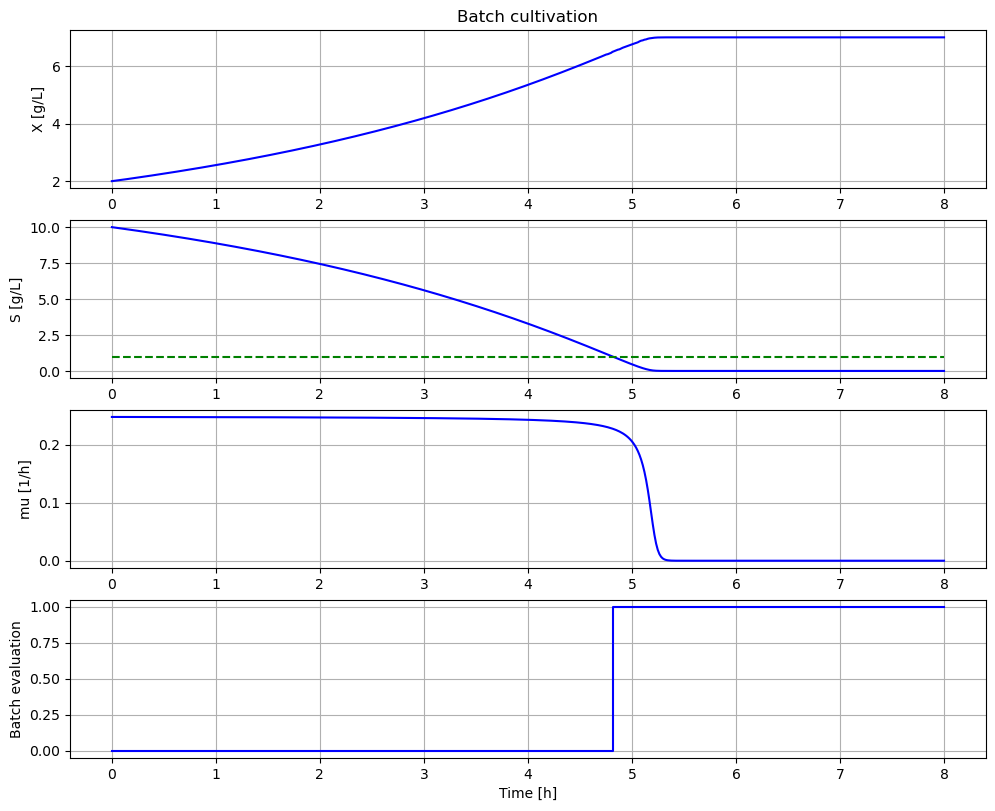

In [4]:
# Simulation of nominal parameters that gives a batch that meed the end criteria
newplot(plotType='TimeSeries_2')
simu(8)

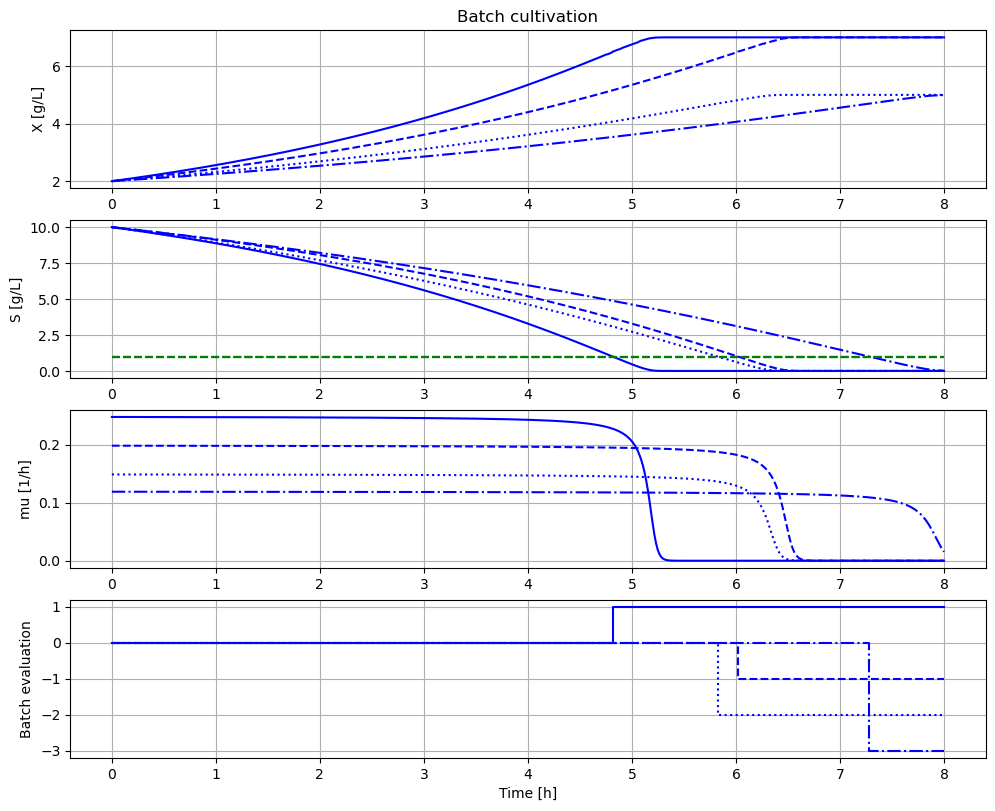

In [5]:
# Exammple of process parameter changes and how they meet the end criteria
newplot(plotType='TimeSeries_2')
par(Y=0.50, qSmax=0.50); simu(8)  # - pass (solid line)
par(Y=0.50, qSmax=0.40); simu(8)  # - fail criteria time_final < 6.0 (dashed line)
par(Y=0.30, qSmax=0.50); simu(8)  # - fail criteria X_final > 5.0 (dotted line)
par(Y=0.30, qSmax=0.40); simu(8)  # - fail both criteria (dash dotted line)

We see that the accepted batch (solid line) finish first. The batches that fail take longer time and two of them has also lower cell concentration at the end.

## 1.2 Batch evaluation under process variation - parameter sweep

Now let us systematically sweep through a number of combinations of process parameters Y and qSmax and evaluate the batches and visualise the result.

In [6]:
# Define sweep ranges and storage of final data
nY = 20
nqSmax = 20
Y_range = np.linspace(0.3,0.5,nY)
qSmax_range = np.linspace(0.4,0.6,nqSmax)
data = np.zeros([nY,nqSmax,5])

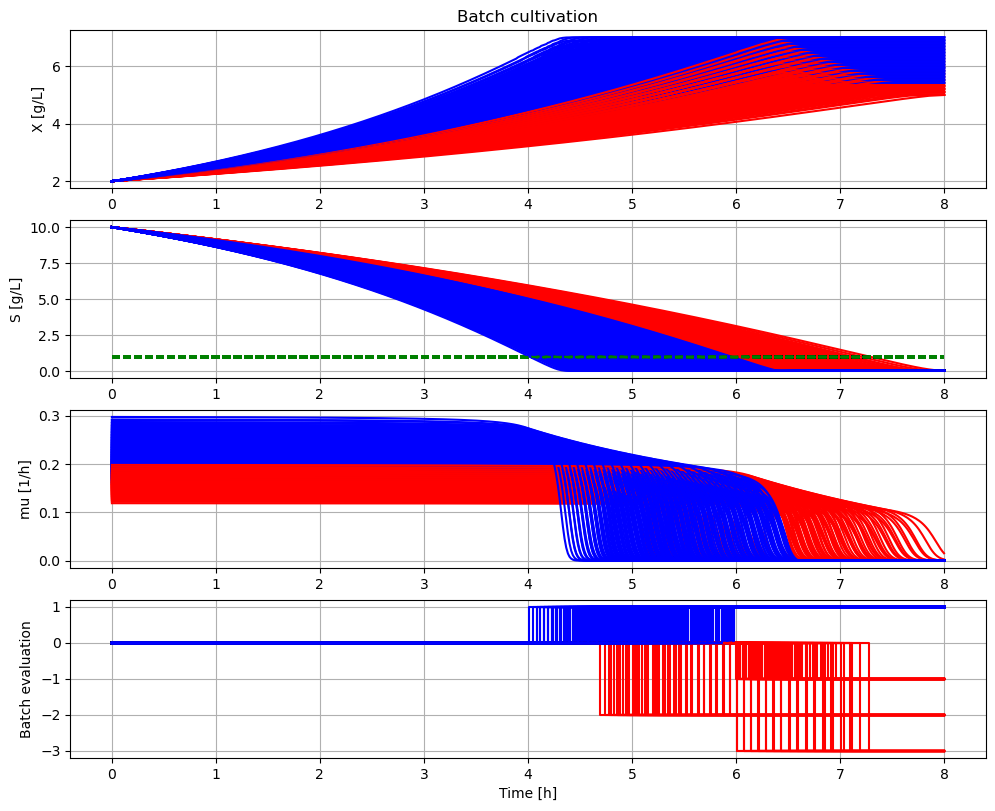

In [7]:
# Run parameter sweep - takes a few minutes
newplot(plotType='TimeSeries_2_diagrams')
init(VX_start=2, VS_start=10)

for j in range(nY):
    for k in range(nqSmax):
        par(Y=Y_range[j])
        par(qSmax=qSmax_range[k])
        simu(8)
                       
        # Store final results
        data[j,k,0] = Y_range[j]
        data[j,k,1] = qSmax_range[k]
        data[j,k,2] = sim_res['monitor.time_final'][-1]
        data[j,k,3] = sim_res['monitor.X_final'][-1]
        data[j,k,4] = sim_res['monitor.batch_evaluation'][-1]
        
        # Plot simulation results
        if sim_res['monitor.batch_evaluation'][-1] > 0:
            ax1.plot(sim_res['time'], sim_res['bioreactor.c[1]'],'b-')
            ax2.plot(sim_res['time'], sim_res['bioreactor.c[2]'],'b-') 
            ax2.plot([0, simulationTime], [model.get('monitor.S_min'), model.get('monitor.S_min')],'g--')
            ax3.plot(sim_res['time'], sim_res['bioreactor.culture.q[1]'],'b-')
            ax4.step(sim_res['time'],sim_res['monitor.batch_evaluation'],where='post',color='b',linestyle='-') 
        else:
            ax1.plot(sim_res['time'], sim_res['bioreactor.c[1]'],'r-')   
            ax2.plot(sim_res['time'], sim_res['bioreactor.c[2]'],'r-')  
            ax2.plot([0, simulationTime], [model.get('monitor.S_min'), model.get('monitor.S_min')],'g--')
            ax3.plot(sim_res['time'], sim_res['bioreactor.culture.q[1]'],'r-')            
            ax4.step(sim_res['time'],sim_res['monitor.batch_evaluation'],where='post',color='r',linestyle='-')
            
plt.show()

Batches represented by blue lines are those that in the end got accepted. The red ones failed.

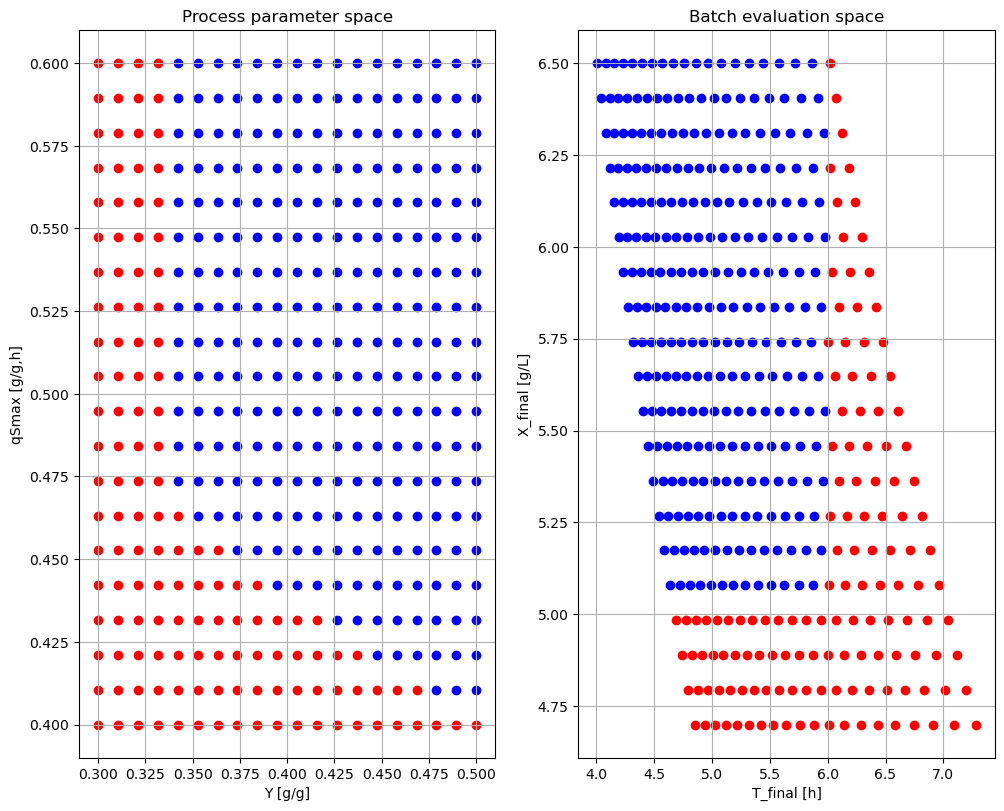

In [8]:
# Show end results
plt.figure()
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

for j in range(nY):
    for k in range(nqSmax):
        if data[j,k,4] > 0: 
            ax1.scatter(data[j,k,0],data[j,k,1],c='b')
        else:
            ax1.scatter(data[j,k,0],data[j,k,1],c='r')           
ax1.grid()
#plt.axis([0, 0.8, 0, 0.8])
ax1.set_ylabel('qSmax [g/g,h]')
ax1.set_xlabel('Y [g/g]')
ax1.set_title('Process parameter space')

for j in range(nY):
    for k in range(nqSmax):
        if data[j,k,4] > 0:         
            ax2.scatter(data[j,k,2],data[j,k,3],c='b')
        else:
            ax2.scatter(data[j,k,2],data[j,k,3],c='r')                 
ax2.grid()
#plt.axis([0, 8, 0, 8])
ax2.set_xlabel('T_final [h]')
ax2.set_ylabel('X_final [g/L]')
ax2.set_title('Batch evaluation space')
plt.show()

Here we visualize the previous simulations results in a different way with foucse on the end result. Each dot in the left diagram (process parameter space) represent a simulation that give a result in the rigiht diagam (batch evaluation space). The blue dots are those batches that were accepted and the red ones those that failed. 

The blue dots in the process parameter space show the "design space" for the acceptance criteria we have. 

## 2 Batch end detection - with measurement noise

Here we load a system model with normal noise added to the sampled value of substrate concentration. The measurement of substrate conentration usually has a higher variation than measuremetn of cell concentration and therefore we focus here on the impact on substrate conentrations.

Thus detection of end of batch is now in discrete time with a give samplePeriod (default 0.1 hour). This discreteization also introduce an error in detection of the end point. By changing this sample intervall to shorter values you can see the impact of this error but not done here.

In [9]:
run -i BPL_TEST2_Batch_with_noise_explore.py

Linux - run FMU pre-compiled OpenModelica

Model for the process has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values/units

Note that both disp() and describe() takes values from the last simulation
and the command process_diagram() brings up the main configuration

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


## 2.1 Batch evaluation under substrate measurement error

Here we see an example of how substrate measurement noise directly affect the evaluation of the batch from accetable to not acceptable.

In [10]:
# Nominal parameters
par(S_min=1.0, time_final_max=6.0, X_final_min=5.0)
init(VX_start=2, VS_start=10)
par(Y=0.5, qSmax=0.5, Ks=0.1)
par(sigma=0.48, samplePeriod=0.1)

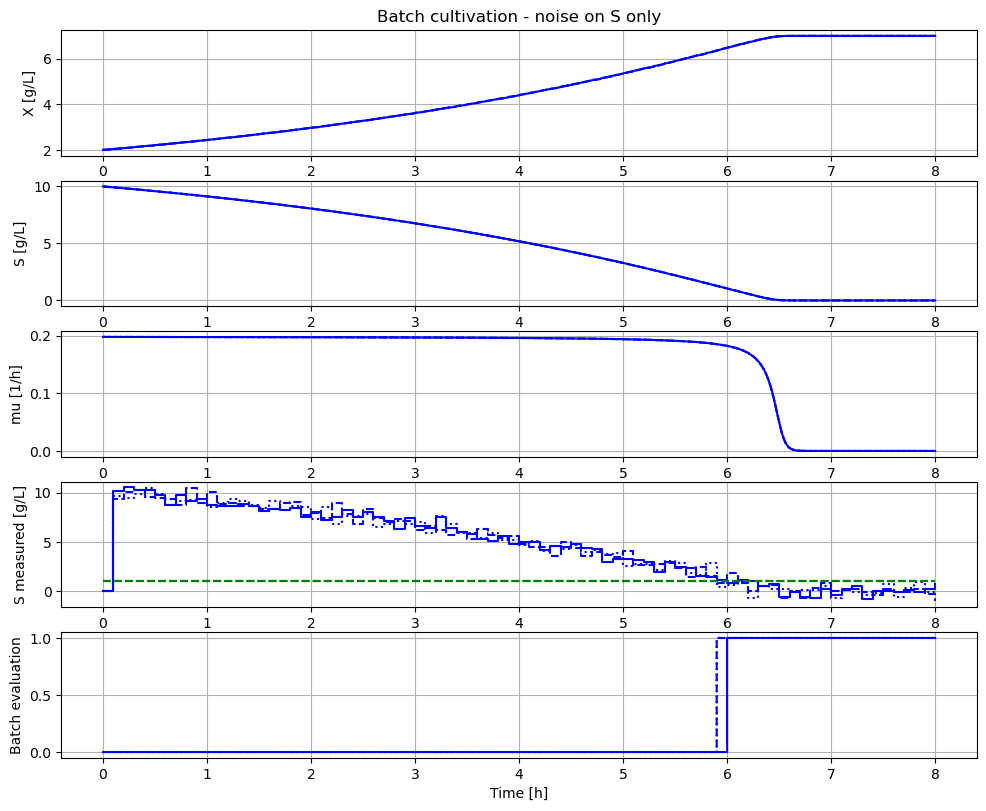

In [11]:
# Simulation of nominal parameters that gives a batch that meed the end criteria
newplot(plotType='TimeSeries_2')
par(Y=0.5, qSmax=0.4); 
for value in [2,3,5]: par(seed=value); simu(8)

## 2.2 Batch evaluation under process variation and measurement error - parameter sweep

Now let us again systematically sweep through a number of combinations of process parameters Y and qSmax and evaluate the batches and visualise their result.

In [12]:
# Define sweep ranges and storage of final data
nY = 20
nqSmax = 20
Y_range = np.linspace(0.3,0.5,nY)
qSmax_range = np.linspace(0.4,0.6,nqSmax)
data = np.zeros([nY,nqSmax,5])

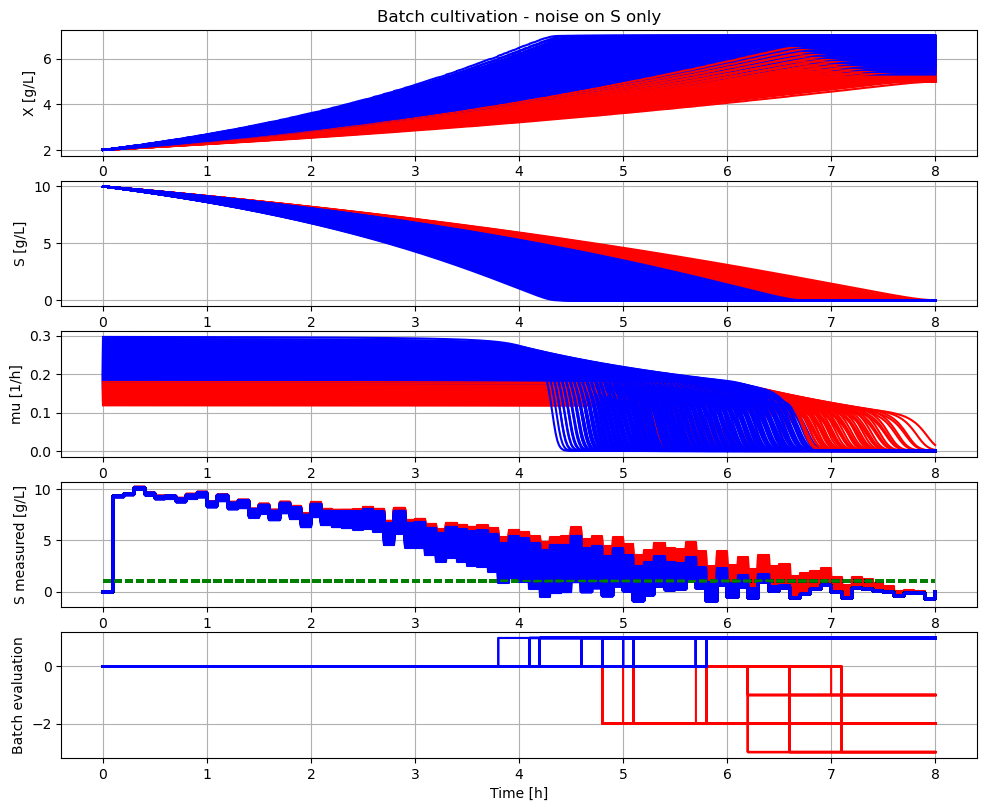

In [13]:
# Run parameter sweep - takes a few minutes
newplot(plotType='TimeSeries_2_diagrams')
par(sigma=0.48, seed=1, samplePeriod=0.1)

for j in range(nY):
    for k in range(nqSmax):
        par(Y=Y_range[j])
        par(qSmax=qSmax_range[k])
        simu(8)
                       
        # Store final results
        data[j,k,0] = Y_range[j]
        data[j,k,1] = qSmax_range[k]
        data[j,k,2] = sim_res['monitor.time_final'][-1]
        data[j,k,3] = sim_res['monitor.X_final'][-1]
        data[j,k,4] = sim_res['monitor.batch_evaluation'][-1]
        
        # Plot simulation results
        if sim_res['monitor.batch_evaluation'][-1] > 0:
            ax1.plot(sim_res['time'], sim_res['bioreactor.c[1]'],'b-')
            ax2.plot(sim_res['time'], sim_res['bioreactor.c[2]'],'b-') 
            ax3.plot(sim_res['time'], sim_res['bioreactor.culture.q[1]'],'b-')
            ax4.plot(sim_res['time'], sim_res['sensor.out.c[2]'],'b-')
            ax4.plot([0, simulationTime], [model.get('monitor.S_min'), model.get('monitor.S_min')],'g--')
            ax5.step(sim_res['time'],sim_res['monitor.batch_evaluation'],where='post',color='b',linestyle='-') 
        else:
            ax1.plot(sim_res['time'], sim_res['bioreactor.c[1]'],'r-')   
            ax2.plot(sim_res['time'], sim_res['bioreactor.c[2]'],'r-')             
            ax3.plot(sim_res['time'], sim_res['bioreactor.culture.q[1]'],'r-')            
            ax4.plot(sim_res['time'], sim_res['sensor.out.c[2]'],'r-')
            ax4.plot([0, simulationTime], [model.get('monitor.S_min'), model.get('monitor.S_min')],'g--') 
            ax5.step(sim_res['time'],sim_res['monitor.batch_evaluation'],where='post',color='r',linestyle='-')
            
plt.show()

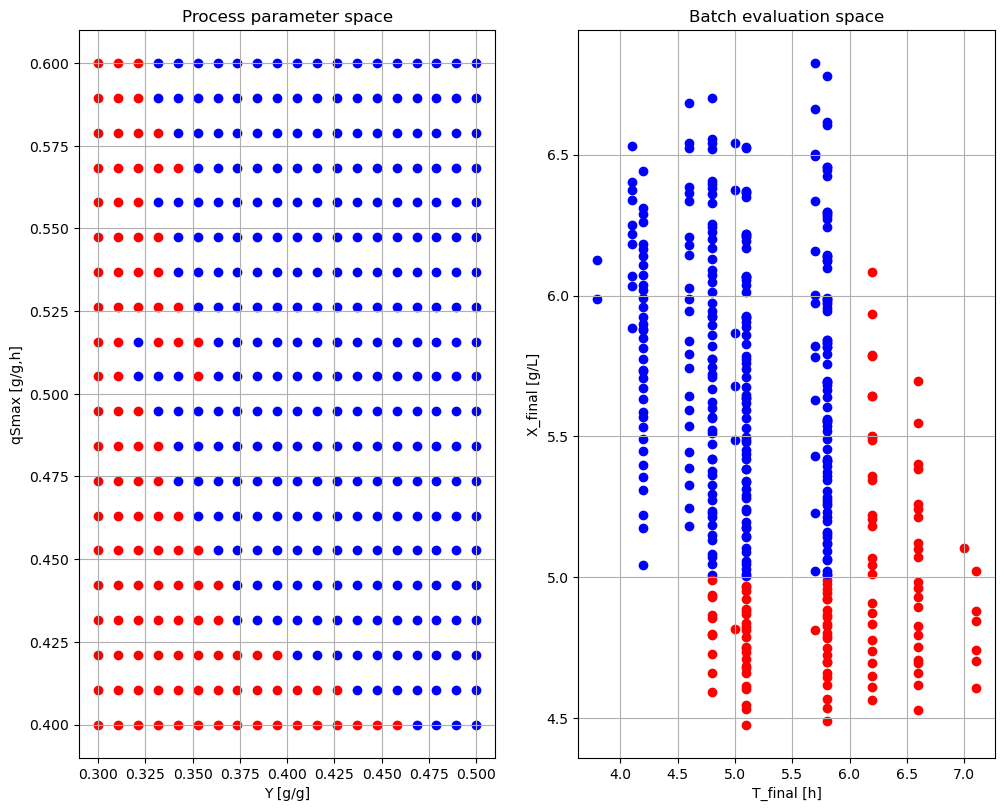

In [14]:
# Show end results
plt.figure()
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

for j in range(nY):
    for k in range(nqSmax):
        if data[j,k,4] > 0: 
            ax1.scatter(data[j,k,0],data[j,k,1],c='b')
        else:
            ax1.scatter(data[j,k,0],data[j,k,1],c='r')           
ax1.grid()
#plt.axis([0, 0.8, 0, 0.8])
ax1.set_ylabel('qSmax [g/g,h]')
ax1.set_xlabel('Y [g/g]')
ax1.set_title('Process parameter space')

for j in range(nY):
    for k in range(nqSmax):
        if data[j,k,4] > 0:         
            ax2.scatter(data[j,k,2],data[j,k,3],c='b')
        else:
            ax2.scatter(data[j,k,2],data[j,k,3],c='r')                 
ax2.grid()
#plt.axis([0, 8, 0, 8])
ax2.set_xlabel('T_final [h]')
ax2.set_ylabel('X_final [g/L]')
ax2.set_title('Batch evaluation space')
plt.show()

We see that we get somwehat different results in the parameter space. The acceptable region with blue dots (design space) get a more rounded corner. The vertical left line is also more rugged.

With much more simulations we could get a better idea of the probablity that a batch is accepted and determine the design space in proabilistic sense.  

## 3 Summary

We have worked through a simple example of evaluation of batch cuöture with given acceptance criteria and how that criteria can be translated to acceptable variation in process parameters, i.e. the design space.

In the deterministic case we get a rather clear cut design space.

In the more realistic case with subsrate measurment noise included we get a more complicated design space, but still similar.

The stochastic model introduce erorrs both due to the added normal noise in the substrate concentration, and due to the fact that we use time discrete system for the noise. The impact of the time discrete check when batch has ended can be made smaller by chosing a smaller sample intervall. This was not studied here and is left for the interested reader.

Note...

## References

[1] Axelsson J.P. and A. Elsheikh: “An example of sensitivity analysis of a bioprocess using Bioprocess Library for Modelica”, Proceedings MODPROD, Linköping, Sweden 2019, see presentation
[here](https://modprodblog.wordpress.com/modprod-2019/).


## Appendix

In [15]:
disp('culture')

Y : 0.5
qSmax : 0.6
Ks : 0.1


In [16]:
describe('mu')

Cell specific growth rate variable : 0.0 [ 1/h ]


In [17]:
describe('parts')

['bioreactor', 'bioreactor.culture', 'monitor', 'sensor']


In [18]:
describe('MSL')

MSL: 4.1.0 - used components: Noise.NormalNoise


In [19]:
# The information about the FMU is just for that last loaded one
system_info()


System information
 -OS: Linux
 -Python: 3.12.9
 -Scipy: not installed in the notebook
 -PyFMI: 2.18.0
 -FMU by: OpenModelica Compiler OpenModelica 1.26.0~dev-200-gcb3254b
 -FMI: 2.0
 -Type: FMUModelME2
 -Name: BPL_TEST2.BatchWithNoise
 -Generated: 2025-07-29T10:17:58Z
 -MSL: 4.1.0
 -Description: Bioprocess Library version 2.3.1
 -Interaction: FMU-explore version 1.0.0


In [20]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 24.04.3 LTS
Release:	24.04
Codename:	noble
